In [19]:
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.mlls import ExactMarginalLogLikelihood

# Define a custom ExactGP model
class GPRegressionModel(ExactGP):
    def __init__(self, likelihood, train_x, train_y):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [20]:
# Initialize likelihood
likelihood = GaussianLikelihood()

# Initialize model
model = GPRegressionModel(likelihood, torch.empty(0), torch.empty(0))

In [21]:
# Set model and likelihood to training mode
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [22]:
# Define a function for the training loop
def train_model(train_x_, train_y_, model_, mll_, likelihood_, optimizer_, itr=10):
    # Find optimal model hyperparameters
    model_.train()
    likelihood_.train()
    
    for i in range(itr):
        # Zero gradients from previous iteration
        optimizer_.zero_grad()
        # Output from model
        output = model_(train_x_)
        # Calculate loss
        loss = -mll_(output, train_y_)    # might need to do .mean() for batched inputs
        
        # print('Loss shape:', loss.shape)  # Add this line for diagnostic
        # Backward pass
        loss.backward()
        
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, itr, loss.item(),
            model_.covar_module.base_kernel.lengthscale.item(),
            model_.likelihood.noise.item()
        ))
    
        optimizer_.step()

In [23]:
from matplotlib import pyplot as plt


def plot(model_, likelihood_, train_x, train_y, test_x):
    # Get into evaluation (predictive posterior) mode
    model_.eval()
    likelihood_.eval()
    
    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.squeeze().numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.squeeze().numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

torch.Size([8])
Iter 1/100 - Loss: 1.152   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.138   lengthscale: 0.693   noise: 0.693
Iter 3/100 - Loss: 1.126   lengthscale: 0.693   noise: 0.693
Iter 4/100 - Loss: 1.114   lengthscale: 0.693   noise: 0.693
Iter 5/100 - Loss: 1.104   lengthscale: 0.693   noise: 0.693
Iter 6/100 - Loss: 1.095   lengthscale: 0.693   noise: 0.693
Iter 7/100 - Loss: 1.089   lengthscale: 0.693   noise: 0.693
Iter 8/100 - Loss: 1.084   lengthscale: 0.693   noise: 0.693
Iter 9/100 - Loss: 1.081   lengthscale: 0.693   noise: 0.693
Iter 10/100 - Loss: 1.079   lengthscale: 0.693   noise: 0.693
Iter 11/100 - Loss: 1.080   lengthscale: 0.693   noise: 0.693
Iter 12/100 - Loss: 1.082   lengthscale: 0.693   noise: 0.693
Iter 13/100 - Loss: 1.084   lengthscale: 0.693   noise: 0.693
Iter 14/100 - Loss: 1.086   lengthscale: 0.693   noise: 0.693
Iter 15/100 - Loss: 1.087   lengthscale: 0.693   noise: 0.693
Iter 16/100 - Loss: 1.088   lengthscale: 0.693   noise: 0.693
I

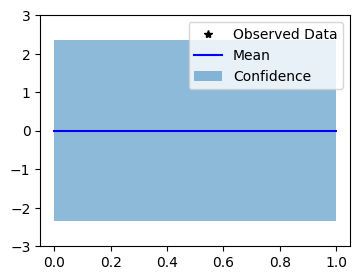

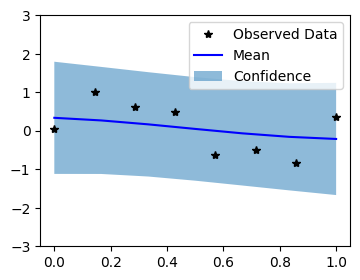

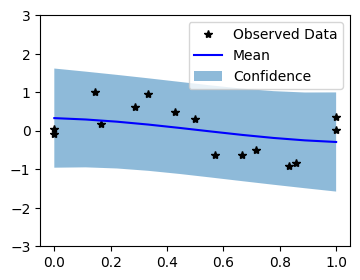

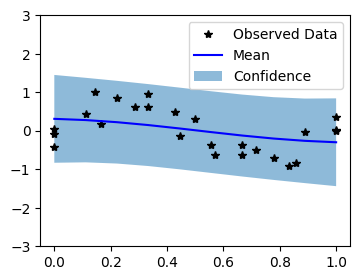

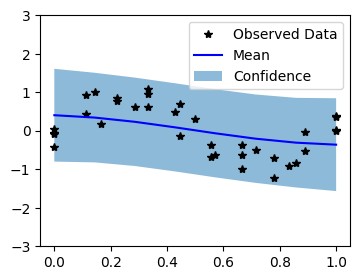

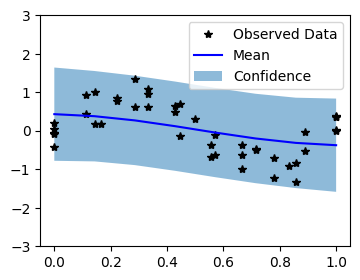

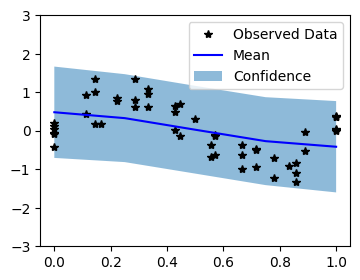

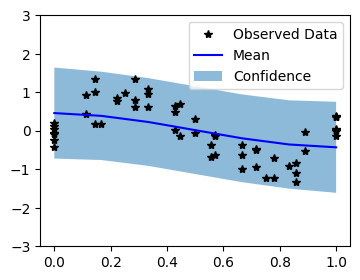

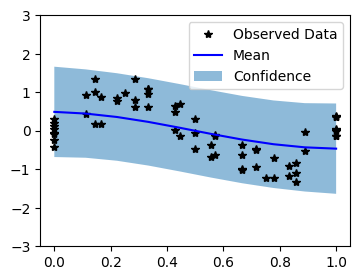

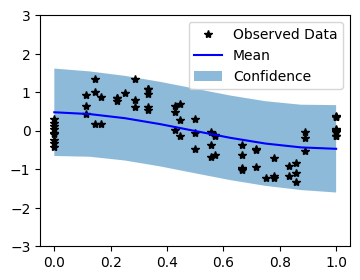

In [24]:
import random

# Initialize empty training data
train_x = torch.empty(0)
train_y = torch.empty(0)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters  

# Now, suppose you start receiving new data
for i in range(10):  # Assuming you receive 5 batches of new data
    # Generate new data (for demonstration purposes)
    new_data_x = torch.linspace(0, 1, 5 + random.randint(0, 5))
    new_data_y = torch.sin(new_data_x * (2 * 3.1416)) + torch.randn(new_data_x.size()) * 0.3

    plot(model, likelihood, train_x, train_y, new_data_x)

    # Update model with new data
    if train_x is not None:
        train_x = torch.cat([train_x, new_data_x])
        train_y = torch.cat([train_y, new_data_y])
        
    print(train_y.shape)
        
    # Update model with new data
    # This is not an efficient update.
    model = model.get_fantasy_model(new_data_x, new_data_y)  
    
    train_model(train_x, train_y, model, mll, likelihood, optimizer, 10)